In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
users_df = pd.read_csv('../raw_data/users.csv')
# centers_df = pd.read_csv('../raw_data/distribution_centers.csv')
# events_df = pd.read_csv('../raw_data/events.csv')
# inventory_items_df = pd.read_csv('../raw_data/inventory_items.csv')
order_items_df = pd.read_csv('../raw_data/order_items.csv')
orders_df = pd.read_csv('../raw_data/orders.csv')
products_df = pd.read_csv('../raw_data/products.csv')

## Data Exploration

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

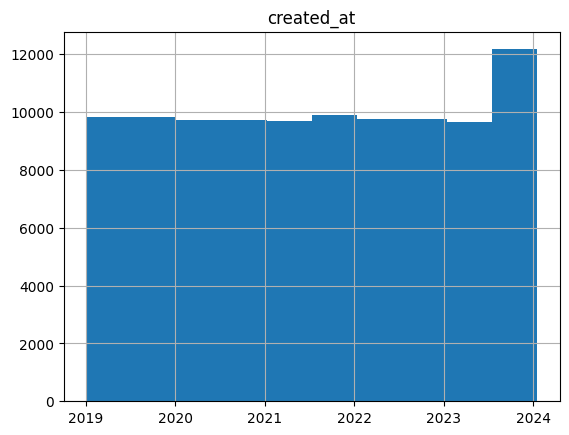

In [3]:
# Check users
users_df_test = users_df.copy()
users_df_test['created_at'] = pd.to_datetime(users_df_test['created_at'],format='mixed').dt.tz_localize(None)
users_df_test.hist('created_at')

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

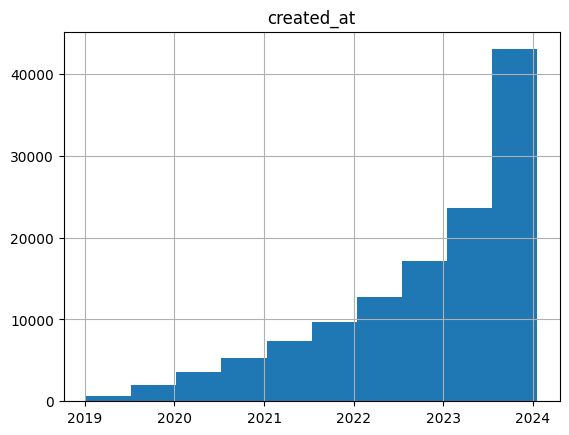

In [4]:
# Check order trend
orders_test = orders_df.copy()
orders_test['created_at'] = pd.to_datetime(orders_test['created_at'],format='mixed').dt.tz_localize(None)
orders_test.hist('created_at')

## Return Datetime Format of order dataset. 
## And calculate each order's revenue

In [5]:
def data_cleaning(order_items_df, orders_df):
    '''
    This function takes the order_items and the orders tables, aggregates the order_items table,
    merges the tables, cleans the datatypes and returns the cleaned dataframe
    '''

    # Agreegate the sale_price by order_id and merge the orders table
    order_sales = order_items_df[['order_id','sale_price']].groupby(by='order_id').sum('sale_price').reset_index()
    cleaned_order_sales = orders_df.merge(order_sales, on='order_id', how='left')

    # Convert the created_at column from 'object' to datetime64
    cleaned_order_sales['created_at'] = pd.to_datetime(cleaned_order_sales['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['returned_at'] = pd.to_datetime(cleaned_order_sales['returned_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['shipped_at'] = pd.to_datetime(cleaned_order_sales['shipped_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['delivered_at'] = pd.to_datetime(cleaned_order_sales['delivered_at'],
                                                       format='mixed').dt.tz_localize(None)


    return cleaned_order_sales

## Order level information 
### Calculates RFM

In [8]:
orders_test = data_cleaning(order_items_df, orders_df)

In [16]:
temp_date = dt.datetime(2024,1,1)
min_date = orders_test['created_at'].min()
int((temp_date - min_date).days/5)

364

In [37]:
def order_features(orders_df, order_items_df, split_date):
    '''
    Calculates features required for XBG
    inputs order_df, order_items_df, products_df
    Assumes revenue per order is already calculated in sale_price column,
    all the datetime fields and split_date should be in datetime format
    '''

    orders_df = data_cleaning(order_items_df, orders_df)

    # Days calculation
    orders_df['days_to_split_date'] = (split_date - orders_df['created_at']).dt.days
    orders_df['days_delivery'] = (orders_df['delivered_at'] - orders_df['created_at']).dt.days

    # Filter data only for last 2 years
    # orders_df = orders_df[(orders_df.days_to_split_date >= 0) & (orders_df.days_to_split_date < days_history)]
    orders_df = orders_df[orders_df.created_at < split_date] # changed to take all historical data

    # Base dataset : user level
    base = orders_df[['user_id','order_id']].groupby('user_id').count().rename(columns={'order_id': 'orders_total'})
    rev_total = orders_df[['user_id','sale_price']].groupby('user_id').sum().rename(columns={'sale_price': 'revenue_total'})
    base = base.merge(rev_total,on='user_id',how='left')

    # Calculate first purchase, latest purchase
    first_purchase = orders_df[['user_id','created_at']].groupby('user_id').min().rename(columns={'created_at': 'min_created_at'})
    base = base.merge(first_purchase, on='user_id')
    latest_purchase = orders_df[['user_id','created_at']].groupby('user_id').max().rename(columns={'created_at': 'max_created_at'})
    base = base.merge(latest_purchase, on='user_id')

    # Days from first/last order (Recency, customer T)
    base['days_from_first_order'] =  (split_date - base['min_created_at']).dt.days # This is customer T
    base['days_from_last_order'] =  (split_date - base['max_created_at']).dt.days # This is recency
    base['order_frequency'] =  base['days_from_first_order']/base['orders_total'] # how many orders did he/she make since first purchase
    

    min_date = orders_df['created_at'].min()
    time_total = (temp_date - min_date).days
    time_section = int(time_total/5)
    
    # Count of orders per period
    df_5 = orders_df[orders_df.days_to_split_date < time_section]
    df_4 = orders_df[(orders_df.days_to_split_date >= time_section) & (orders_df.days_to_split_date < time_section*2)]
    df_3 = orders_df[(orders_df.days_to_split_date >= time_section*2) & (orders_df.days_to_split_date < time_section*3)]
    df_2 = orders_df[(orders_df.days_to_split_date >= time_section*3) & (orders_df.days_to_split_date < time_section*4)]
    df_1 = orders_df[(orders_df.days_to_split_date >= time_section*4) & (orders_df.days_to_split_date < time_total)]

    # orders per different timeframe
    f_5 = df_5[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_5'})
    f_4 = df_4[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_4'})
    f_3 = df_3[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_3'})
    f_2 = df_2[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_2'})
    f_1 = df_1[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_1'})

    # Frequency Joined to base dataset
    base = base.merge(f_5,on='user_id',how='left')
    base = base.merge(f_4,on='user_id',how='left')
    base = base.merge(f_3,on='user_id',how='left')
    base = base.merge(f_2,on='user_id',how='left')
    base = base.merge(f_1,on='user_id',how='left')

    # orders per different timeframe
    m_5 = df_5[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_5'})
    m_4 = df_4[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_4'})
    m_3 = df_3[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_3'})
    m_2 = df_2[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_2'})
    m_1 = df_1[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_1'})

    # Monetary Joined to base dataset
    base = base.merge(m_5,on='user_id',how='left')
    base = base.merge(m_4,on='user_id',how='left')
    base = base.merge(m_3,on='user_id',how='left')
    base = base.merge(m_2,on='user_id',how='left')
    base = base.merge(m_1,on='user_id',how='left')

    # ABV calculation
    base['abv'] = base['revenue_total']/base['orders_total']

    # Other calcs (delivery, num_items)
    avg_delivery_days = orders_df[['user_id','days_delivery']].groupby('user_id').mean().rename(columns={'days_delivery': 'avg_delivery_days'})
    base = base.merge(avg_delivery_days, on='user_id')
    avg_items_p_order = orders_df[['user_id','num_of_item']].groupby('user_id').mean().rename(columns={'num_of_item': 'avg_num_items'})
    base = base.merge(avg_items_p_order, on='user_id')

    # Fill NA with 0 for selected columns
    selected_columns = [
        'orders_total',
        'revenue_total',
        'orders_5',
        'orders_4',
        'orders_3',
        'orders_2',
        'orders_1',
        'revenue_1',
        'revenue_2',
        'revenue_3',
        'revenue_4',
        'revenue_5']

    base[selected_columns] = base[selected_columns].fillna(0)

    return base

In [24]:
temp_date = dt.datetime(2024,1,1)
result = order_features(orders_df, order_items_df, temp_date)
result.head(10)

,orders_total,revenue_total,min_created_at,max_created_at,days_from_first_order,days_from_last_order,orders_5,orders_4,orders_3,orders_2,orders_1,revenue_5,revenue_4,revenue_3,revenue_2,revenue_1,abv,avg_delivery_days,avg_num_items
user_id,,,,,,,,,,,,,,,,,,,
1,1,159.990000,2022-07-18 12:55:00,2022-07-18 12:55:00,531,531,0.0,1.0,0.0,0.0,0.0,0.000000,159.990000,0.000000,0.000000,0.0,159.990000,NaN,3.00
2,1,22.000000,2022-02-20 10:34:00,2022-02-20 10:34:00,679,679,0.0,1.0,0.0,0.0,0.0,0.000000,22.000000,0.000000,0.000000,0.0,22.000000,3.0,1.00
3,4,402.200001,2023-03-10 09:13:00,2023-08-08 09:13:00,296,145,4.0,0.0,0.0,0.0,0.0,402.200001,0.000000,0.000000,0.000000,0.0,100.550000,3.0,1.25
4,1,148.000000,2022-10-18 09:31:00,2022-10-18 09:31:00,439,439,0.0,1.0,0.0,0.0,0.0,0.000000,148.000000,0.000000,0.000000,0.0,148.000000,2.0,1.00
5,1,65.650000,2022-10-20 10:03:00,2022-10-20 10:03:00,437,437,0.0,1.0,0.0,0.0,0.0,0.000000,65.650000,0.000000,0.000000,0.0,65.650000,NaN,3.00
6,1,144.820004,2022-04-08 04:38:00,2022-04-08 04:38:00,632,632,0.0,1.0,0.0,0.0,0.0,0.000000,144.820004,0.000000,0.000000,0.0,144.820004,NaN,2.00
7,1,84.209999,2022-02-26 16:52:00,2022-02-26 16:52:00,673,673,0.0,1.0,0.0,0.0,0.0,0.000000,84.209999,0.000000,0.000000,0.0,84.209999,NaN,1.00
8,1,80.689999,2021-07-15 17:15:00,2021-07-15 17:15:00,899,899,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,80.689999,0.000000,0.0,80.689999,NaN,2.00
9,2,543.489986,2020-05-23 17:44:00,2023-11-02 17:44:00,1317,59,1.0,0.0,0.0,1.0,0.0,71.950001,0.000000,0.000000,471.539986,0.0,271.744993,NaN,3.00


array([[<Axes: title={'center': 'orders_total'}>]], dtype=object)

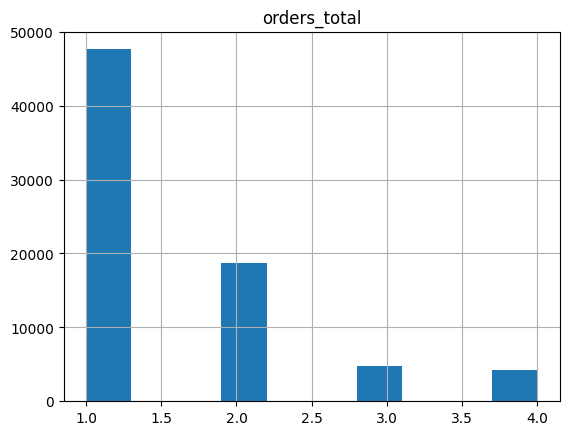

In [38]:
result.hist('orders_total')

## Join item level dataframe into one

In [26]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     # 'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id'})

    order_items_df['created_at'] = pd.to_datetime(order_items_df['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               # 'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

## Check to see if we can group brand

In [28]:
item_level_df = join_tables_item_level(order_items_df, products_df)

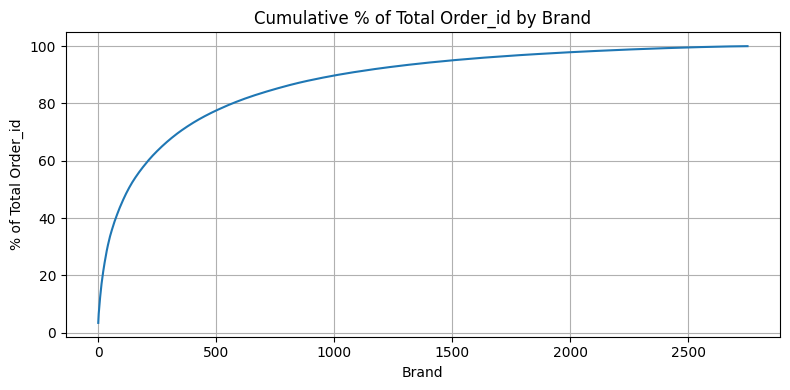

In [29]:
# Checking top brands 

data_agg = item_level_df[['order_id','brand']].groupby(by='brand').count().sort_values(by='order_id', ascending=False).reset_index()

# Calculate cumulative sum of 'order_id' for each brand
data_agg['cumulative_sum'] = data_agg['order_id'].cumsum()

# Calculate percentage of total 'order_id'
total_orders = data_agg['order_id'].sum()
data_agg['percentage'] = (data_agg['cumulative_sum'] / total_orders) * 100

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.lineplot(x=data_agg.index, y=data_agg['percentage'])
plt.xlabel('Brand')
plt.ylabel('% of Total Order_id')
plt.title('Cumulative % of Total Order_id by Brand')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


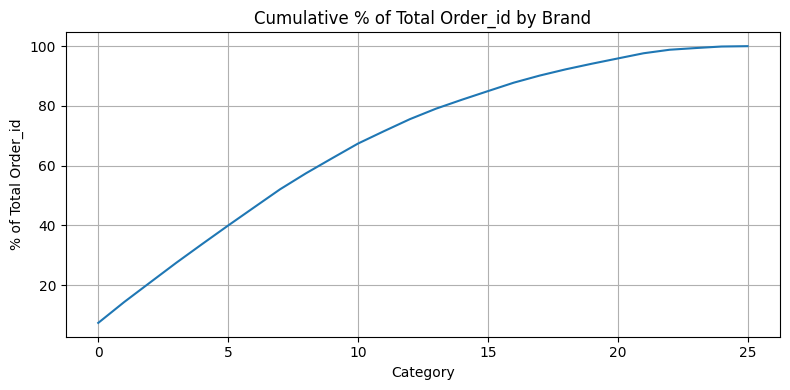

In [30]:
# Checking top brands 

data_agg = item_level_df[['order_id','category']].groupby(by='category').count().sort_values(by='order_id', ascending=False).reset_index()

# Calculate cumulative sum of 'order_id' for each brand
data_agg['cumulative_sum'] = data_agg['order_id'].cumsum()

# Calculate percentage of total 'order_id'
total_orders = data_agg['order_id'].sum()
data_agg['percentage'] = (data_agg['cumulative_sum'] / total_orders) * 100

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.lineplot(x=data_agg.index, y=data_agg['percentage'])
plt.xlabel('Category')
plt.ylabel('% of Total Order_id')
plt.title('Cumulative % of Total Order_id by Brand')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


## - Joined Dataframe Aggregation
### -- Calculates preffered brand and category

In [40]:
def calc_product_features(item_level_df, split_date):
    '''
    takes item-level dataframe and calculate features to user level.
    '''

    # filter data only for last 2 years -> changed to whole period
    # min_date = split_date - pd.DateOffset(days=days_history)
    # item_level_df = item_level_df[(item_level_df['created_at'] <= split_date) & (item_level_df['created_at'] > min_date)].copy()
    item_level_df = item_level_df[(item_level_df['created_at'] <= split_date)].copy()
    
    # # Calculate the first orders
    # item_level_df['order_rank'] = item_level_df.groupby('user_id')['created_at'].rank().astype(int) # calculating the order of orders
    # item_level_df['order_rank_desc'] = item_level_df.groupby('user_id')['created_at'].rank(method='max').astype(int) # calculating the order of orders

    base = item_level_df[['user_id','order_item_id']].groupby('user_id').count().fillna(0).rename(columns={'order_item_id':'num_order_item'})
    
    # # taking value for the very first order
    # intial_values = item_level_df[item_level_df['order_rank']==1][['user_id','category','brand']].rename(columns={'category':'categ_initial',
    #                                                                                                               'brand':'brand_initial'})
    # base = base.merge(intial_values, on='user_id', how='left')

    # # taking value for the very last order
    # last_values = item_level_df[item_level_df['order_rank_desc']==1][['user_id','category','brand']].rename(columns={'category':'categ_last',
    #                                                                                                               'brand':'brand_last'})
    # base = base.merge(last_values, on='user_id', how='left')

    # item_level_df = item_level_df.rename(columns={'created_at':'order_item_created_at'})

    # Most frequent brand
    count_brands = item_level_df.groupby(['user_id', 'brand']).size().reset_index(name='count')
    idx = count_brands.groupby(['user_id'])['count'].transform('max') == count_brands['count']
    preffered_brand = count_brands[idx].drop(columns='count').rename(columns={'brand':'brand_preffered'})

    base = base.merge(preffered_brand, on='user_id', how='left')

    # Most frequent category
    count_cat = item_level_df.groupby(['user_id', 'category']).size().reset_index(name='count')
    idx = count_cat.groupby(['user_id'])['count'].transform('max') == count_cat['count']
    preffered_cat = count_cat[idx].drop(columns='count').rename(columns={'category':'category_preffered'})

    base = base.merge(preffered_cat, on='user_id', how='left')

    return base

## User dataset

In [177]:
def select_user_columns(users_df, split_date):

    df = users_df[['id','age','country','created_at','traffic_source']].rename(columns={'id':'user_id','created_at':'user_created_at'})
    # Filter users only for last 2 years from split date
    # min_date = split_date - pd.DateOffset(days=365*5)
    df['user_created_at'] = pd.to_datetime(df['user_created_at'], format='mixed').dt.tz_localize(None)
    df = df[(df['user_created_at'] <= split_date)]
    
    return df

## Y Actual

In [49]:
def create_y_actual(order_items_df, split_date, days_predict):
    df = order_items_df[['id','user_id','created_at','sale_price']].copy().rename(columns={'id':'order_item_id'})
    df['order_created_at'] = pd.to_datetime(df['created_at'], format='mixed').dt.tz_localize(None)

    # select next 90 days of revenue from split_date
    max_date = split_date + pd.DateOffset(days=days_predict)
    df = df[(df['order_created_at'] <= max_date) & (df['order_created_at'] > split_date)]
    
    df_agg = df[['user_id','sale_price']].groupby('user_id').sum().fillna(0).rename(columns={'sale_price':'future_clv'})

    return df_agg

In [50]:
# Setting test dataset

test_date = dt.datetime(2024,1,1)
item_level_df = join_tables_item_level(order_items_df, products_df)

In [178]:
df_user = select_user_columns(users_df, test_date)
df_order = order_features(orders_df, order_items_df, test_date)
df_item = calc_product_features(item_level_df, test_date)
df_y_actual = create_y_actual(order_items_df, test_date, 180)

In [52]:
df_item.columns

Index(['user_id', 'num_order_item', 'brand_preffered', 'category_preffered'], dtype='object')

## Join all the prepped datasets

In [179]:
def prep_input_dataset(df_user, df_order, df_item, df_y_actual):
    '''
    joins all preprocessed user-level-df
    '''
    
    final_df = df_user.merge(df_order, on='user_id', how='left')
    final_df = final_df.merge(df_item, on='user_id', how='left')
    final_df = final_df.merge(df_y_actual, on='user_id', how='left')

    final_df = final_df[final_df['orders_total']>0].copy()

    final_df = final_df.reset_index()

    return final_df


In [180]:
input_dataset = prep_input_dataset(df_user, df_order, df_item, df_y_actual)
input_dataset.columns

Index(['index', 'user_id', 'age', 'country', 'user_created_at',
       'traffic_source', 'orders_total', 'revenue_total', 'min_created_at',
       'max_created_at', 'days_from_first_order', 'days_from_last_order',
       'order_frequency', 'orders_5', 'orders_4', 'orders_3', 'orders_2',
       'orders_1', 'revenue_5', 'revenue_4', 'revenue_3', 'revenue_2',
       'revenue_1', 'abv', 'avg_delivery_days', 'avg_num_items',
       'num_order_item', 'brand_preffered', 'category_preffered',
       'future_clv'],
      dtype='object')

## Preprocessor Pipelines

In [181]:
# List of columns to drop
columns_to_drop = ['user_id','index','brand_preffered','avg_delivery_days','future_clv']

X = input_dataset.drop(columns=columns_to_drop).copy()
y = input_dataset[['future_clv']].fillna(0).copy()

array([[<Axes: title={'center': 'future_clv'}>]], dtype=object)

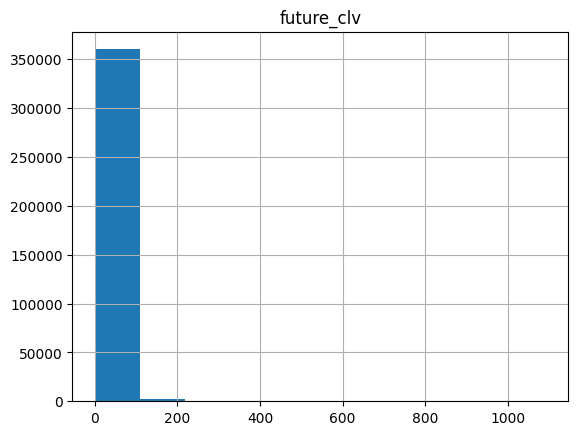

In [182]:
y.hist()

In [183]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf33a30>)])

In [184]:
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf33a30>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [185]:
X.columns

Index(['age', 'country', 'user_created_at', 'traffic_source', 'orders_total',
       'revenue_total', 'min_created_at', 'max_created_at',
       'days_from_first_order', 'days_from_last_order', 'order_frequency',
       'orders_5', 'orders_4', 'orders_3', 'orders_2', 'orders_1', 'revenue_5',
       'revenue_4', 'revenue_3', 'revenue_2', 'revenue_1', 'abv',
       'avg_num_items', 'num_order_item', 'category_preffered'],
      dtype='object')

## Model Selection

In [186]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring='r2').mean()
# Given negative MSE result
score_baseline

-1.217398198237562

## Train Test Split, Fit, Evaluation

In [187]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf33a30>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [189]:
y_decision = pipe_baseline.predict(X_test)
y_decision

array([0., 0., 0., ..., 0., 0., 0.])

In [195]:
y_decision.min()

0.0

In [190]:
from sklearn.metrics import r2_score

# Assuming you have y and y_pred defined
r2 = r2_score(y_test, y_decision)
print("R-squared:", r2)

R-squared: 0.8261371179470253


In [197]:
pipe_xgb = make_pipeline(preproc_baseline, XGBRegressor(objective='reg:squarederror'))
pipe_xgb

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [198]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [199]:
y_xgb = pipe_xgb.predict(X_test)
y_xgb

array([-4.3002553 ,  0.2341506 , -7.8587503 , ...,  1.0953959 ,
       -0.10785292, 12.774162  ], dtype=float32)

In [201]:
y_xgb_0 = np.maximum(y_xgb, 0)

In [202]:
# Assuming you have y and y_pred defined
r2 = r2_score(y_test, y_xgb_0)
print("R-squared:", r2)

R-squared: 0.7013569798222024


In [203]:
pipe_randomforest = make_pipeline(preproc_baseline, RandomForestRegressor())
pipe_randomforest

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf33a30>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [207]:
pipe_randomforest.fit(X_train, y_train['future_clv'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf31c60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f749cf33a30>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [208]:
y_randomforest = pipe_randomforest.predict(X_test)
r2 = r2_score(y_test, y_randomforest)
print("R-squared:", r2)

R-squared: 0.899831021491792


## Metric and dry-run

In [70]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
# Given negative MSE result
score_baseline

-1700.567528938384

## Iteration

In [ ]:
# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## Linear Models

In [66]:
# Check shape
preproc_fitted = preproc_baseline.fit(X,y)
# preproc_fitted_log = preproc_baseline.fit(X,y_log)
print(preproc_fitted.transform(X).shape)
# print(preproc_fitted_log.transform(X).shape)

(363700, 61)


In [67]:
# Ridge with normal target
model = Ridge()

pipe_ridge = make_pipeline(preproc_baseline, model)

cross_val_score(pipe_ridge, X, y, cv=5, scoring='r2').mean()

0.00983716521547955

# Questions

- how can i have negative r2 when doing cross_validation and much higher r2 fitting and evaluating.
- how can i plot feature importance of each model?
- 